<a href="https://colab.research.google.com/github/raagzz/capstone-project/blob/main/Tab_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Installing the required packages
!pip install git+https://github.com/modAL-python/modAL.git
!pip install openml

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-0wfu9srr
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-0wfu9srr
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.2 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32647 sha256=7f11212efb38d2715ce8f1496d050567e273881afc4667ca141297c0f5b54606
  Stored in directory: /tmp/pip-ephem-wheel-cache-aqwgbgmf/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/

In [97]:
##Importing Packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_classification

import openml

from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling
from modAL.disagreement import vote_entropy_sampling

## Generating Data

In [115]:
X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
### Initial Data For Tarining
initial_idx = np.random.choice(range(len(X_train)), size=100, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

In [117]:
### Pool Data - Unlabeled
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

## Random Sampling - Baseline

In [118]:
def random_sampling(learner, X_pool, n_samples=1):
    ''' Randomly selects n_samples from X_pool '''
    n_pool = len(X_pool)
    query_idx = np.random.choice(range(n_pool), size=n_samples, replace=False)
    return query_idx, X_pool[query_idx]

In [119]:
learner_random = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial
)

##Uncertainty Sampling

In [120]:
learner_uncertainty = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

## Entropy Sampling

In [121]:
learner_entropy = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)

## Margin Sampling

In [122]:
learner_margin = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=margin_sampling,
    X_training=X_initial, y_training=y_initial
)

## Query by Committee

In [123]:
##numbers of members in the committe
n_members = 5
##Models
committee_estimators = [RandomForestClassifier() for _ in range(n_members)]
learner_committee = Committee(
    learner_list=[
        ActiveLearner(
            estimator=estimator,
            X_training=X_initial,
            y_training=y_initial
        ) for estimator in committee_estimators
    ],
    query_strategy=vote_entropy_sampling  ##Vote entropy sampling for disagreement-based querying
)

### Active Learning Parameters
- Number of queries (```n_queries = 50```)
- Accuracy
- F1 Score

In [124]:
### Helper Variables
n_queries = 50
performance_baseline = []
performance_entropy = []
performance_uncertainty = []
performance_committee = []
performance_margin = []

## Active Learning Loop

In [125]:
def run_active_learning(learner, X_pool, y_pool, strategy_name):
    '''Keeps the loop running and capture the performance of the model'''
    performance = []
    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        y_pred = learner.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        performance.append((acc, f1))
        print(f"{strategy_name} | Query {i+1}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")
    return performance

### Run active learning and store performance

In [126]:
performance_baseline = run_active_learning(learner_random, X_pool.copy(), y_pool.copy(), "Random Sampling")

Random Sampling | Query 1: Accuracy = 0.8040, F1-Score = 0.7897
Random Sampling | Query 2: Accuracy = 0.7800, F1-Score = 0.7609
Random Sampling | Query 3: Accuracy = 0.7880, F1-Score = 0.7735
Random Sampling | Query 4: Accuracy = 0.7753, F1-Score = 0.7718
Random Sampling | Query 5: Accuracy = 0.7920, F1-Score = 0.7787
Random Sampling | Query 6: Accuracy = 0.7860, F1-Score = 0.7679
Random Sampling | Query 7: Accuracy = 0.7867, F1-Score = 0.7768
Random Sampling | Query 8: Accuracy = 0.7727, F1-Score = 0.7569
Random Sampling | Query 9: Accuracy = 0.8080, F1-Score = 0.8000
Random Sampling | Query 10: Accuracy = 0.7900, F1-Score = 0.7899
Random Sampling | Query 11: Accuracy = 0.7733, F1-Score = 0.7578
Random Sampling | Query 12: Accuracy = 0.7720, F1-Score = 0.7588
Random Sampling | Query 13: Accuracy = 0.7840, F1-Score = 0.7705
Random Sampling | Query 14: Accuracy = 0.8007, F1-Score = 0.7887
Random Sampling | Query 15: Accuracy = 0.7887, F1-Score = 0.7763
Random Sampling | Query 16: Accura

In [127]:
performance_uncertainty = run_active_learning(learner_uncertainty, X_pool.copy(), y_pool.copy(), "Uncertainty Sampling")

Uncertainty Sampling | Query 1: Accuracy = 0.7800, F1-Score = 0.7734
Uncertainty Sampling | Query 2: Accuracy = 0.7813, F1-Score = 0.7790
Uncertainty Sampling | Query 3: Accuracy = 0.7613, F1-Score = 0.7584
Uncertainty Sampling | Query 4: Accuracy = 0.7867, F1-Score = 0.7820
Uncertainty Sampling | Query 5: Accuracy = 0.7620, F1-Score = 0.7540
Uncertainty Sampling | Query 6: Accuracy = 0.7760, F1-Score = 0.7686
Uncertainty Sampling | Query 7: Accuracy = 0.7567, F1-Score = 0.7625
Uncertainty Sampling | Query 8: Accuracy = 0.7887, F1-Score = 0.7848
Uncertainty Sampling | Query 9: Accuracy = 0.7773, F1-Score = 0.7658
Uncertainty Sampling | Query 10: Accuracy = 0.7787, F1-Score = 0.7757
Uncertainty Sampling | Query 11: Accuracy = 0.7860, F1-Score = 0.7853
Uncertainty Sampling | Query 12: Accuracy = 0.7673, F1-Score = 0.7696
Uncertainty Sampling | Query 13: Accuracy = 0.7833, F1-Score = 0.7757
Uncertainty Sampling | Query 14: Accuracy = 0.7713, F1-Score = 0.7643
Uncertainty Sampling | Query 

In [128]:
performance_entropy = run_active_learning(learner_entropy, X_pool.copy(), y_pool.copy(), "Entropy Sampling")

Entropy Sampling | Query 1: Accuracy = 0.7780, F1-Score = 0.7676
Entropy Sampling | Query 2: Accuracy = 0.7820, F1-Score = 0.7746
Entropy Sampling | Query 3: Accuracy = 0.7767, F1-Score = 0.7675
Entropy Sampling | Query 4: Accuracy = 0.7840, F1-Score = 0.7756
Entropy Sampling | Query 5: Accuracy = 0.7840, F1-Score = 0.7784
Entropy Sampling | Query 6: Accuracy = 0.7807, F1-Score = 0.7707
Entropy Sampling | Query 7: Accuracy = 0.7960, F1-Score = 0.7872
Entropy Sampling | Query 8: Accuracy = 0.7840, F1-Score = 0.7762
Entropy Sampling | Query 9: Accuracy = 0.7933, F1-Score = 0.7801
Entropy Sampling | Query 10: Accuracy = 0.7947, F1-Score = 0.7843
Entropy Sampling | Query 11: Accuracy = 0.7913, F1-Score = 0.7782
Entropy Sampling | Query 12: Accuracy = 0.7880, F1-Score = 0.7729
Entropy Sampling | Query 13: Accuracy = 0.8000, F1-Score = 0.7881
Entropy Sampling | Query 14: Accuracy = 0.7873, F1-Score = 0.7739
Entropy Sampling | Query 15: Accuracy = 0.7833, F1-Score = 0.7674
Entropy Sampling | 

In [129]:
performance_committee = run_active_learning(learner_committee, X_pool.copy(), y_pool.copy(), "Query by Committee")

Query by Committee | Query 1: Accuracy = 0.7853, F1-Score = 0.7773
Query by Committee | Query 2: Accuracy = 0.7867, F1-Score = 0.7721
Query by Committee | Query 3: Accuracy = 0.7807, F1-Score = 0.7694
Query by Committee | Query 4: Accuracy = 0.7927, F1-Score = 0.7880
Query by Committee | Query 5: Accuracy = 0.7840, F1-Score = 0.7759
Query by Committee | Query 6: Accuracy = 0.7807, F1-Score = 0.7748
Query by Committee | Query 7: Accuracy = 0.7833, F1-Score = 0.7700
Query by Committee | Query 8: Accuracy = 0.7927, F1-Score = 0.7814
Query by Committee | Query 9: Accuracy = 0.7953, F1-Score = 0.7870
Query by Committee | Query 10: Accuracy = 0.8040, F1-Score = 0.7961
Query by Committee | Query 11: Accuracy = 0.8000, F1-Score = 0.7893
Query by Committee | Query 12: Accuracy = 0.7980, F1-Score = 0.7912
Query by Committee | Query 13: Accuracy = 0.8087, F1-Score = 0.8003
Query by Committee | Query 14: Accuracy = 0.8147, F1-Score = 0.8085
Query by Committee | Query 15: Accuracy = 0.8087, F1-Scor

In [130]:
performance_margin = run_active_learning(learner_margin, X_pool.copy(), y_pool.copy(), "Margin Sampling")

Margin Sampling | Query 1: Accuracy = 0.7820, F1-Score = 0.7728
Margin Sampling | Query 2: Accuracy = 0.7760, F1-Score = 0.7680
Margin Sampling | Query 3: Accuracy = 0.7813, F1-Score = 0.7799
Margin Sampling | Query 4: Accuracy = 0.7820, F1-Score = 0.7756
Margin Sampling | Query 5: Accuracy = 0.7687, F1-Score = 0.7628
Margin Sampling | Query 6: Accuracy = 0.7640, F1-Score = 0.7552
Margin Sampling | Query 7: Accuracy = 0.7707, F1-Score = 0.7621
Margin Sampling | Query 8: Accuracy = 0.7773, F1-Score = 0.7755
Margin Sampling | Query 9: Accuracy = 0.7700, F1-Score = 0.7698
Margin Sampling | Query 10: Accuracy = 0.7673, F1-Score = 0.7690
Margin Sampling | Query 11: Accuracy = 0.7700, F1-Score = 0.7702
Margin Sampling | Query 12: Accuracy = 0.7573, F1-Score = 0.7580
Margin Sampling | Query 13: Accuracy = 0.7800, F1-Score = 0.7737
Margin Sampling | Query 14: Accuracy = 0.7973, F1-Score = 0.7880
Margin Sampling | Query 15: Accuracy = 0.7713, F1-Score = 0.7687
Margin Sampling | Query 16: Accura

## Helper Steps For Plotting

In [131]:
acc_baseline, f1_baseline = zip(*performance_baseline)
acc_uncertainty, f1_uncertainty = zip(*performance_uncertainty)
acc_entropy, f1_entropy = zip(*performance_entropy)
acc_committee, f1_committee = zip(*performance_committee)
acc_margin, f1_margin = zip(*performance_margin)
sns.set(style="whitegrid")

## Plotting the Performance over the queries

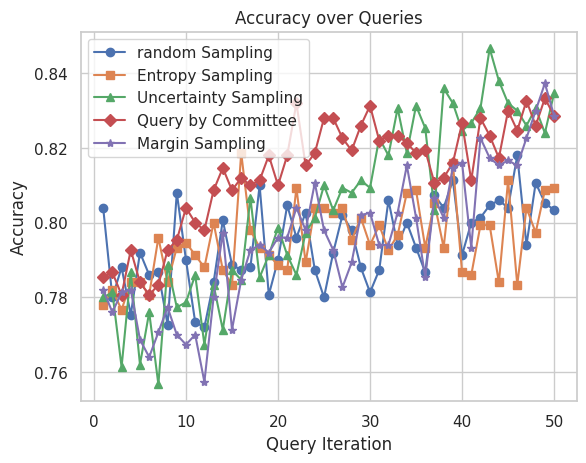

In [132]:
plt.plot(range(1, n_queries + 1), acc_baseline, label='random Sampling', marker='o')
plt.plot(range(1, n_queries + 1), acc_entropy, label='Entropy Sampling', marker='s')
plt.plot(range(1, n_queries + 1), acc_uncertainty, label='Uncertainty Sampling', marker='^')
plt.plot(range(1, n_queries + 1), acc_committee, label='Query by Committee', marker='D')
plt.plot(range(1, n_queries + 1), acc_margin, label='Margin Sampling', marker='*')
plt.title("Accuracy over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy")
plt.legend()

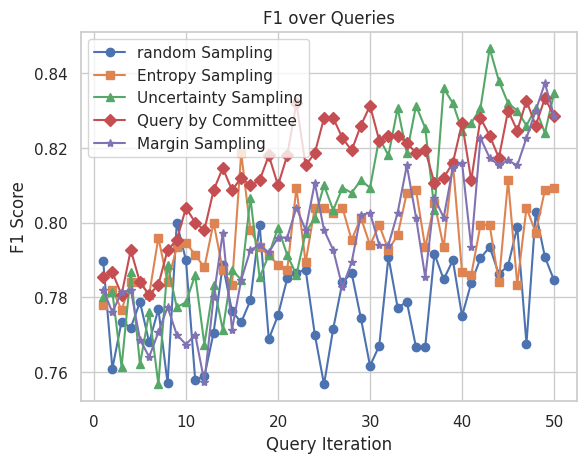

In [133]:
plt.plot(range(1, n_queries + 1), f1_baseline, label='random Sampling', marker='o')
plt.plot(range(1, n_queries + 1), acc_entropy, label='Entropy Sampling', marker='s')
plt.plot(range(1, n_queries + 1), acc_uncertainty, label='Uncertainty Sampling', marker='^')
plt.plot(range(1, n_queries + 1), acc_committee, label='Query by Committee', marker='D')
plt.plot(range(1, n_queries + 1), acc_margin, label='Margin Sampling', marker='*')
plt.title("F1 over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Score")
plt.legend()